In [1]:
import warnings
warnings.filterwarnings("ignore")
import re
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import sys
import shutil
import pickle
import seaborn as sns
sns.set_style('whitegrid')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from keras.models import Model, Sequential, load_model
from keras import optimizers, losses, callbacks, regularizers
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Concatenate, Dropout
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler, Callback
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
with open('/home/jupyter/RL_paper/element_sets/roost_unique_elem_dict.pkl', 'rb') as f:
    roost_elem_dict = pickle.load(f)
element_list = roost_elem_dict['mp-bulk-mod.csv']

In [4]:
def train_model(prop, prop_2, iteration, weight):
    def counts2vector(pairs):
        vec = [0]*len(element_list)
        for pair in pairs:
            vec[element_list.index(pair[0])]+=int(pair[1])
        vec = np.array(vec)
        return vec

    def onehot(enc):
        rep = np.zeros((84,11))
        rep[:,0] = 1
        for i,val in enumerate(enc):
            if val!=0:
                rep[i][0]=0
                rep[i][val]=1
        return rep.flatten()

    def encode(df_to_encode):
        formulae = df_to_encode[['comp']]
        counts = pd.Series(formulae.values.flatten()).str.findall(r"([a-z]+)([0-9]+)", re.I)
        res = []
        for count in counts:
            res.append(counts2vector(count))
        df_to_encode['encoding'] = res
        # df_to_encode['encoding'] = counts.apply(counts2vector)
        # df_to_encode['onehot'] = df_to_encode['encoding'].apply(onehot)
        res_2 = []
        for encod in res:
            res_2.append(onehot(encod))
        df_to_encode['onehot'] = res_2

    def sample_z(args):
        mu, log_sigma = args
        eps = K.random_normal(shape=(n_z,), mean=0., stddev=1.)
        return mu + K.exp(log_sigma / 2.) * eps

    def vae_loss(y_true, y_pred):

        # Reconstruction Loss
        y_true_reshaped=tf.reshape(y_true,[-1,84,11])
        recon = 10 * K.mean(K.sum(K.categorical_crossentropy(y_true_reshaped, y_pred, axis=2),axis=1))

        # KL Divergence Loss
        kl = 0.05 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

        #Total loss
        return recon + kl

    class DecoderSaveCheckpoint(Callback):
        def __init__(self, filepath, decoder):
            self.monitor = 'val_loss'
            self.monitor_op = np.less
            self.best = np.Inf

            self.filepath = filepath
            self.decoder = decoder

        def on_epoch_end(self, epoch, logs=None):
            current = logs.get(self.monitor)
            if self.monitor_op(current, self.best):
                self.best = current
            self.decoder.save(self.filepath, overwrite=True)
    
    with open(f'/home/jupyter/CJK/RL/paper/data/{prop}_data.pkl', 'rb') as f:
        properties = pickle.load(f)
    with open(f'/home/jupyter/CJK/RL/paper/data/{prop_2}_data.pkl', 'rb') as f:
        properties_2 = pickle.load(f)
    df_orig = pd.read_csv('/home/jupyter/CJK/RL/data/mp_all_data_cleaned_oxides_csv.csv')
    
    df = pd.DataFrame()
    df['comp'] = df_orig['pretty_formula_coeff']
    if prop == 'sinter_temp' or prop == 'calcine_temp':
        properties = [x/100 for x in properties]
    if prop_2 == 'sinter_temp' or prop_2 == 'calcine_temp':
        properties_2 = [x/100 for x in properties_2]
    df[prop] = [x*float(weight) for x in properties]
    df[prop_2] = [x*(1-float(weight)) for x in properties]
    
    df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
    
    encode(df_train)
    encode(df_test)
    
    X_train = df_train.onehot.values
    X_train = np.stack(X_train,axis=0)
    X_test = df_test.onehot.values
    X_test = np.stack(X_test,axis=0)
    y_train = np.concatenate((df_train[[prop]].values, df_train[[prop_2]].values), axis=1)
    y_test = np.concatenate((df_test[[prop]].values, df_test[[prop_2]].values), axis=1)
    
    n_z = 32  # dimension of latent space
    n_x = X_train.shape[1] 
    n_y = y_train.shape[1]

    X = Input(shape=(n_x,))
    cond = Input(shape=(n_y,))

    inputs = Concatenate(axis=1)([X,cond])
    h_q = Dense(512, activation='relu')(inputs)
    h_q1= Dense(256, activation='relu')(h_q)
    h_q2= Dense(128, activation='relu')(h_q1)
    mu = Dense(n_z, activation='linear')(h_q2)
    log_sigma = Dense(n_z, activation='linear')(h_q2)
    
    
    z = Lambda(sample_z)([mu, log_sigma])
    z_cond = Concatenate(axis=1)([z, cond])

    decoder_hidden = Dense(128, activation='relu')
    decoder_hidden_1 = Dense(256, activation='relu')
    decoder_hidden_2 = Dense(512, activation='relu')
    decoder_out = Dense(n_x, activation='linear')
    decoder_out_act = Lambda(lambda x: K.softmax(K.reshape(x,(-1,84,11)), axis=2))

    h_p = decoder_hidden(z_cond)
    h_p1=decoder_hidden_1(h_p)
    h_p2=decoder_hidden_2(h_p1)

    outputs = decoder_out_act(decoder_out(h_p2))
    
    vae = Model([X,cond], outputs)
    
    
    # We use the mean as the output as it is the center point, the representative of the gaussian
    encoder = Model([X,cond], mu)

    # Generator model, generate new data given latent variable z
    d_cond = Input(shape=(n_y,))
    d_z = Input(shape=(n_z,))
    d_inputs = Concatenate(axis=1)([d_z,d_cond])
    d_h = decoder_hidden(d_inputs)
    d_h1 = decoder_hidden_1(d_h)
    d_h2 = decoder_hidden_2(d_h1)
    d_out = decoder_out_act(decoder_out(d_h2))
    decoder = Model([d_z,d_cond], d_out)
    
    vae.compile(optimizer='adam', loss=vae_loss)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=5, min_lr=0.00000001,verbose=1)
    
    losses=[]
    checkpoint=callbacks.ModelCheckpoint(filepath=f'Models/weighted/{prop}_{prop_2}_{iteration}_{weight}_ding_model_best.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    save_loss = callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: [
            losses.append(logs['val_loss'])])
    
    history = vae.fit([X_train, y_train], X_train, batch_size=256, epochs=150, validation_split=0.2,callbacks=[reduce_lr,checkpoint,save_loss, DecoderSaveCheckpoint(f'Models/weighted/{prop}_{prop_2}_{iteration}_{weight}_ding_decoder_best.h5', decoder)])
    
    with open(f'Data/weighted/{prop}_{prop_2}_{iteration}_{weight}_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
        
    plt.figure(figsize=(10,10))
    plt.plot(vae.history.history['loss'])
    plt.plot(vae.history.history['val_loss'])
    plt.title("Performance of DING model with increase in epochs ")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train','Validation'],loc='upper right')
    plt.show()
    
    
    Y_pred = vae.predict([X_test,y_test])
    Y_pred = Y_pred.reshape(-1,84,11)
    
    
    # pred encoding stores the coefficients of the elements in the material
    pred_encoding = np.zeros((Y_pred.shape[0],84))
    Y_pred[Y_pred<0.5]=0

    for i,mol in enumerate(Y_pred):
        for j,atom in enumerate(mol):
            if atom.max()!=0:
                pred_encoding[i][j] = atom.argmax()

    test_encoding = np.zeros_like(pred_encoding)
    for i,mol in enumerate(X_test.reshape(-1,84,11)):
        for j,atom in enumerate(mol):
            if atom.max()!=0:
                test_encoding[i][j] = atom.argmax()
                
                
    accuracy = (np.unique(np.sum(np.abs(pred_encoding - test_encoding),axis=1),return_counts=True))[1]*100/len(X_test)
    with open(f'Data/weighted/{prop}_{prop_2}_{iteration}_{weight}_reconstruction_accuracy.pkl', 'wb') as f:
        pickle.dump(accuracy, f)

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 114us/step - loss: 348.6893 - val_loss: 170.8165

Epoch 00001: val_loss improved from inf to 170.81654, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.1_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 83us/step - loss: 168.6730 - val_loss: 165.9484

Epoch 00002: val_loss improved from 170.81654 to 165.94840, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.1_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 82us/step - loss: 163.7298 - val_loss: 159.9413

Epoch 00003: val_loss improved from 165.94840 to 159.94131, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.1_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 84us/step - loss: 159.3329 - val_loss: 156.6704

Epoch 00004: val_loss improved from 159.94131 to 156.67040, saving model to Models/weighted/sinter

Epoch 35/150
16239/16239 [==============================] - 1s 84us/step - loss: 37.5680 - val_loss: 53.3264

Epoch 00035: val_loss improved from 54.18074 to 53.32638, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.1_ding_model_best.h5
Epoch 36/150
16239/16239 [==============================] - 1s 81us/step - loss: 34.7270 - val_loss: 54.1754

Epoch 00036: val_loss did not improve from 53.32638
Epoch 37/150
16239/16239 [==============================] - 1s 82us/step - loss: 34.1679 - val_loss: 53.1245

Epoch 00037: val_loss improved from 53.32638 to 53.12445, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.1_ding_model_best.h5
Epoch 38/150
16239/16239 [==============================] - 1s 82us/step - loss: 31.7095 - val_loss: 51.1970

Epoch 00038: val_loss improved from 53.12445 to 51.19699, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.1_ding_model_best.h5
Epoch 39/150
16239/16239 [==============================] - 1s 80us/step - loss: 29.5737 - val_loss:

16239/16239 [==============================] - 1s 86us/step - loss: 10.7328 - val_loss: 42.1059

Epoch 00076: val_loss did not improve from 41.10855
Epoch 77/150
16239/16239 [==============================] - 1s 86us/step - loss: 10.7823 - val_loss: 41.7115

Epoch 00077: val_loss did not improve from 41.10855
Epoch 78/150
16239/16239 [==============================] - 1s 83us/step - loss: 10.9208 - val_loss: 42.1325

Epoch 00078: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00078: val_loss did not improve from 41.10855
Epoch 79/150
16239/16239 [==============================] - 1s 83us/step - loss: 10.8122 - val_loss: 41.9128

Epoch 00079: val_loss did not improve from 41.10855
Epoch 80/150
16239/16239 [==============================] - 1s 86us/step - loss: 10.7983 - val_loss: 42.1034

Epoch 00080: val_loss did not improve from 41.10855
Epoch 81/150
16239/16239 [==============================] - 1s 85us/step - loss: 10.7229 - val_loss: 41.7638

Epoch 00081:


Epoch 00125: val_loss did not improve from 41.10855
Epoch 126/150
16239/16239 [==============================] - 1s 84us/step - loss: 10.5998 - val_loss: 42.0258

Epoch 00126: val_loss did not improve from 41.10855
Epoch 127/150
16239/16239 [==============================] - 1s 86us/step - loss: 10.6769 - val_loss: 41.8770

Epoch 00127: val_loss did not improve from 41.10855
Epoch 128/150
16239/16239 [==============================] - 1s 85us/step - loss: 10.7190 - val_loss: 41.9073

Epoch 00128: val_loss did not improve from 41.10855
Epoch 129/150
16239/16239 [==============================] - 1s 84us/step - loss: 10.8366 - val_loss: 41.7521

Epoch 00129: val_loss did not improve from 41.10855
Epoch 130/150
16239/16239 [==============================] - 1s 85us/step - loss: 10.8048 - val_loss: 41.3257

Epoch 00130: val_loss did not improve from 41.10855
Epoch 131/150
16239/16239 [==============================] - 1s 85us/step - loss: 10.7549 - val_loss: 42.0821

Epoch 00131: val_loss

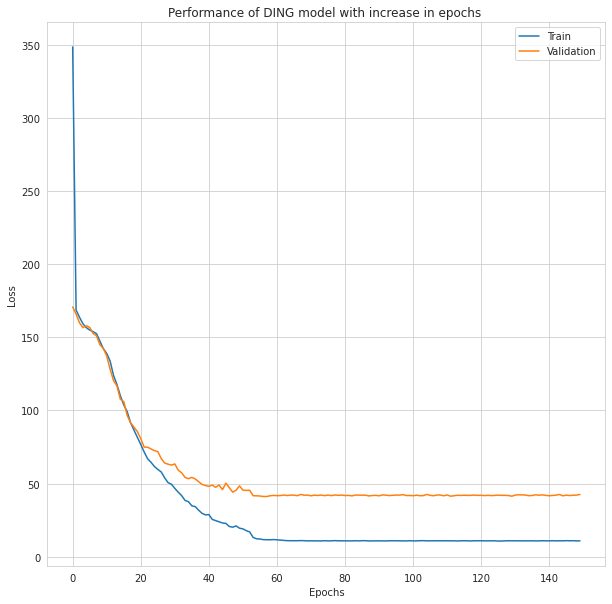

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 127us/step - loss: 348.9195 - val_loss: 169.8861

Epoch 00001: val_loss improved from inf to 169.88612, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.2_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 83us/step - loss: 168.4871 - val_loss: 166.5190

Epoch 00002: val_loss improved from 169.88612 to 166.51901, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.2_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 81us/step - loss: 163.7578 - val_loss: 160.8341

Epoch 00003: val_loss improved from 166.51901 to 160.83407, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.2_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 80us/step - loss: 158.8959 - val_loss: 157.0579

Epoch 00004: val_loss improved from 160.83407 to 157.05786, saving model to Models/weighted/sinter

Epoch 35/150
16239/16239 [==============================] - 1s 83us/step - loss: 30.8528 - val_loss: 46.9951

Epoch 00035: val_loss improved from 48.31774 to 46.99510, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.2_ding_model_best.h5
Epoch 36/150
16239/16239 [==============================] - 1s 83us/step - loss: 28.3020 - val_loss: 49.5069

Epoch 00036: val_loss did not improve from 46.99510
Epoch 37/150
16239/16239 [==============================] - 1s 80us/step - loss: 26.9812 - val_loss: 46.4249

Epoch 00037: val_loss improved from 46.99510 to 46.42486, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.2_ding_model_best.h5
Epoch 38/150
16239/16239 [==============================] - 1s 81us/step - loss: 26.8171 - val_loss: 45.4099

Epoch 00038: val_loss improved from 46.42486 to 45.40988, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.2_ding_model_best.h5
Epoch 39/150
16239/16239 [==============================] - 1s 81us/step - loss: 25.7529 - val_loss:

16239/16239 [==============================] - 1s 83us/step - loss: 8.8502 - val_loss: 38.2597

Epoch 00079: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00079: val_loss did not improve from 37.17187
Epoch 80/150
16239/16239 [==============================] - 1s 82us/step - loss: 8.8746 - val_loss: 37.7366

Epoch 00080: val_loss did not improve from 37.17187
Epoch 81/150
16239/16239 [==============================] - 1s 83us/step - loss: 9.0311 - val_loss: 38.1727

Epoch 00081: val_loss did not improve from 37.17187
Epoch 82/150
16239/16239 [==============================] - 1s 85us/step - loss: 8.8200 - val_loss: 37.9406

Epoch 00082: val_loss did not improve from 37.17187
Epoch 83/150
16239/16239 [==============================] - 1s 83us/step - loss: 8.9575 - val_loss: 37.7810

Epoch 00083: val_loss did not improve from 37.17187
Epoch 84/150
16239/16239 [==============================] - 1s 83us/step - loss: 8.9457 - val_loss: 37.7290

Epoch 00084: Reduc

16239/16239 [==============================] - 1s 81us/step - loss: 8.9487 - val_loss: 38.1259

Epoch 00128: val_loss did not improve from 37.16330
Epoch 129/150
16239/16239 [==============================] - 1s 83us/step - loss: 8.9414 - val_loss: 38.0253

Epoch 00129: val_loss did not improve from 37.16330
Epoch 130/150
16239/16239 [==============================] - 1s 83us/step - loss: 8.8901 - val_loss: 38.4071

Epoch 00130: val_loss did not improve from 37.16330
Epoch 131/150
16239/16239 [==============================] - 1s 84us/step - loss: 8.9623 - val_loss: 38.4429

Epoch 00131: val_loss did not improve from 37.16330
Epoch 132/150
16239/16239 [==============================] - 1s 84us/step - loss: 9.0039 - val_loss: 38.0868

Epoch 00132: val_loss did not improve from 37.16330
Epoch 133/150
16239/16239 [==============================] - 1s 85us/step - loss: 8.9149 - val_loss: 38.3914

Epoch 00133: val_loss did not improve from 37.16330
Epoch 134/150
16239/16239 [===============

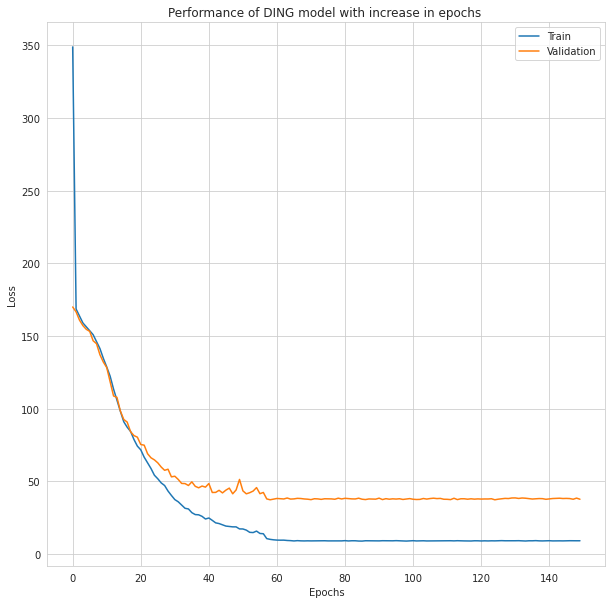

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 121us/step - loss: 346.7608 - val_loss: 170.6942

Epoch 00001: val_loss improved from inf to 170.69425, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.3_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 83us/step - loss: 169.5354 - val_loss: 168.5399

Epoch 00002: val_loss improved from 170.69425 to 168.53987, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.3_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 85us/step - loss: 167.1863 - val_loss: 164.4355

Epoch 00003: val_loss improved from 168.53987 to 164.43551, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.3_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 82us/step - loss: 160.8977 - val_loss: 158.8844

Epoch 00004: val_loss improved from 164.43551 to 158.88442, saving model to Models/weighted/sinter

Epoch 35/150
16239/16239 [==============================] - 1s 85us/step - loss: 45.6836 - val_loss: 58.7987

Epoch 00035: val_loss improved from 60.45555 to 58.79873, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.3_ding_model_best.h5
Epoch 36/150
16239/16239 [==============================] - 1s 84us/step - loss: 44.0392 - val_loss: 57.8340

Epoch 00036: val_loss improved from 58.79873 to 57.83398, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.3_ding_model_best.h5
Epoch 37/150
16239/16239 [==============================] - 1s 84us/step - loss: 41.6164 - val_loss: 54.6319

Epoch 00037: val_loss improved from 57.83398 to 54.63185, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.3_ding_model_best.h5
Epoch 38/150
16239/16239 [==============================] - 1s 81us/step - loss: 40.0922 - val_loss: 58.9288

Epoch 00038: val_loss did not improve from 54.63185
Epoch 39/150
16239/16239 [==============================] - 1s 82us/step - loss: 38.5062 - val_loss:

16239/16239 [==============================] - 1s 84us/step - loss: 11.9850 - val_loss: 42.3712

Epoch 00077: val_loss did not improve from 41.85551
Epoch 78/150
16239/16239 [==============================] - 1s 82us/step - loss: 12.0027 - val_loss: 42.2294

Epoch 00078: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00078: val_loss did not improve from 41.85551
Epoch 79/150
16239/16239 [==============================] - 1s 81us/step - loss: 11.8979 - val_loss: 42.1551

Epoch 00079: val_loss did not improve from 41.85551
Epoch 80/150
16239/16239 [==============================] - 1s 87us/step - loss: 12.1150 - val_loss: 42.0912

Epoch 00080: val_loss did not improve from 41.85551
Epoch 81/150
16239/16239 [==============================] - 1s 83us/step - loss: 11.8850 - val_loss: 42.6945

Epoch 00081: val_loss did not improve from 41.85551
Epoch 82/150
16239/16239 [==============================] - 1s 83us/step - loss: 11.9636 - val_loss: 42.6141

Epoch 00082

16239/16239 [==============================] - 1s 81us/step - loss: 11.8465 - val_loss: 41.9659

Epoch 00126: val_loss did not improve from 41.85551
Epoch 127/150
16239/16239 [==============================] - 1s 82us/step - loss: 11.8740 - val_loss: 42.9162

Epoch 00127: val_loss did not improve from 41.85551
Epoch 128/150
16239/16239 [==============================] - 1s 83us/step - loss: 12.0199 - val_loss: 42.4952

Epoch 00128: val_loss did not improve from 41.85551
Epoch 129/150
16239/16239 [==============================] - 1s 83us/step - loss: 11.9279 - val_loss: 42.1512

Epoch 00129: val_loss did not improve from 41.85551
Epoch 130/150
16239/16239 [==============================] - 1s 83us/step - loss: 11.8613 - val_loss: 42.2986

Epoch 00130: val_loss did not improve from 41.85551
Epoch 131/150
16239/16239 [==============================] - 1s 81us/step - loss: 11.9650 - val_loss: 42.5969

Epoch 00131: val_loss did not improve from 41.85551
Epoch 132/150
16239/16239 [=========

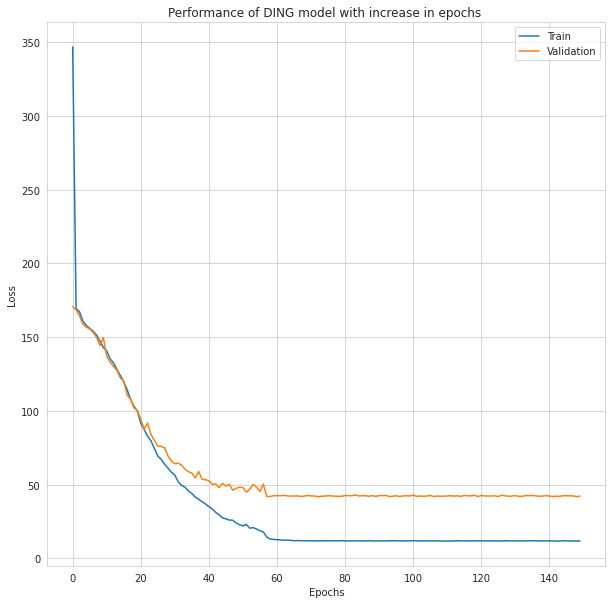

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 126us/step - loss: 346.3185 - val_loss: 170.6318

Epoch 00001: val_loss improved from inf to 170.63179, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.4_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 84us/step - loss: 168.3636 - val_loss: 165.7610

Epoch 00002: val_loss improved from 170.63179 to 165.76097, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.4_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 84us/step - loss: 163.2782 - val_loss: 157.9969

Epoch 00003: val_loss improved from 165.76097 to 157.99688, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.4_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 84us/step - loss: 158.6881 - val_loss: 159.4189

Epoch 00004: val_loss did not improve from 157.99688
Epoch 5/150
16239/16239 [====================

16239/16239 [==============================] - 1s 82us/step - loss: 40.7289 - val_loss: 56.7949

Epoch 00035: val_loss improved from 58.80994 to 56.79490, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.4_ding_model_best.h5
Epoch 36/150
16239/16239 [==============================] - 1s 84us/step - loss: 39.8571 - val_loss: 55.0461

Epoch 00036: val_loss improved from 56.79490 to 55.04606, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.4_ding_model_best.h5
Epoch 37/150
16239/16239 [==============================] - 1s 83us/step - loss: 36.4630 - val_loss: 55.7329

Epoch 00037: val_loss did not improve from 55.04606
Epoch 38/150
16239/16239 [==============================] - 1s 83us/step - loss: 36.4480 - val_loss: 53.2520

Epoch 00038: val_loss improved from 55.04606 to 53.25205, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.4_ding_model_best.h5
Epoch 39/150
16239/16239 [==============================] - 1s 82us/step - loss: 33.2687 - val_loss: 51.6753

Epo

16239/16239 [==============================] - 1s 83us/step - loss: 12.2742 - val_loss: 41.3736

Epoch 00077: val_loss improved from 41.42948 to 41.37356, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.4_ding_model_best.h5
Epoch 78/150
16239/16239 [==============================] - 1s 82us/step - loss: 12.2311 - val_loss: 41.8400

Epoch 00078: val_loss did not improve from 41.37356
Epoch 79/150
16239/16239 [==============================] - 1s 82us/step - loss: 12.2319 - val_loss: 41.6018

Epoch 00079: val_loss did not improve from 41.37356
Epoch 80/150
16239/16239 [==============================] - 1s 82us/step - loss: 12.3482 - val_loss: 42.1794

Epoch 00080: val_loss did not improve from 41.37356
Epoch 81/150
16239/16239 [==============================] - 1s 82us/step - loss: 12.4142 - val_loss: 42.3506

Epoch 00081: val_loss did not improve from 41.37356
Epoch 82/150
16239/16239 [==============================] - 1s 80us/step - loss: 12.3675 - val_loss: 41.7736

Epoch 000


Epoch 00126: val_loss did not improve from 41.37356
Epoch 127/150
16239/16239 [==============================] - 1s 80us/step - loss: 12.2477 - val_loss: 42.2987

Epoch 00127: val_loss did not improve from 41.37356
Epoch 128/150
16239/16239 [==============================] - 1s 82us/step - loss: 12.4095 - val_loss: 42.1273

Epoch 00128: val_loss did not improve from 41.37356
Epoch 129/150
16239/16239 [==============================] - 1s 88us/step - loss: 12.2683 - val_loss: 41.8752

Epoch 00129: val_loss did not improve from 41.37356
Epoch 130/150
16239/16239 [==============================] - 1s 83us/step - loss: 12.4158 - val_loss: 41.9806

Epoch 00130: val_loss did not improve from 41.37356
Epoch 131/150
16239/16239 [==============================] - 1s 80us/step - loss: 12.2172 - val_loss: 41.6716

Epoch 00131: val_loss did not improve from 41.37356
Epoch 132/150
16239/16239 [==============================] - 1s 84us/step - loss: 12.4152 - val_loss: 41.9201

Epoch 00132: val_loss

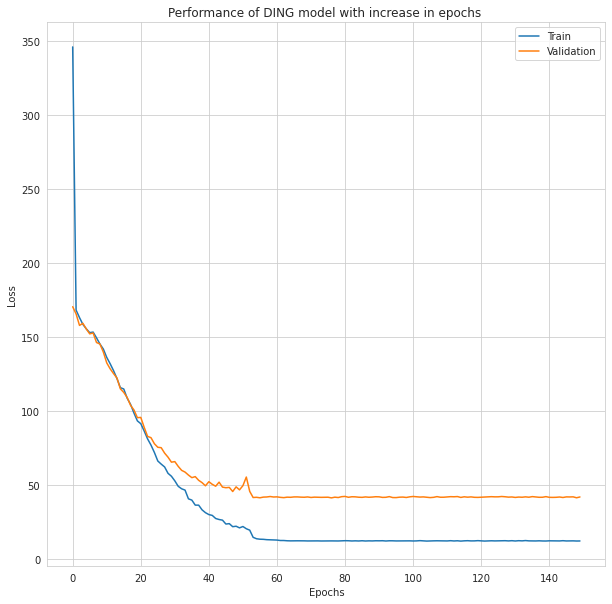

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 126us/step - loss: 367.5334 - val_loss: 177.7877

Epoch 00001: val_loss improved from inf to 177.78769, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.5_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 82us/step - loss: 168.7189 - val_loss: 166.2940

Epoch 00002: val_loss improved from 177.78769 to 166.29396, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.5_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 87us/step - loss: 166.0083 - val_loss: 169.0535

Epoch 00003: val_loss did not improve from 166.29396
Epoch 4/150
16239/16239 [==============================] - 1s 88us/step - loss: 161.9714 - val_loss: 160.5950

Epoch 00004: val_loss improved from 166.29396 to 160.59497, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.5_ding_model_best.h5
Epoch 5/150
16239/16239 [====================

Epoch 35/150
16239/16239 [==============================] - 1s 87us/step - loss: 44.6380 - val_loss: 58.1008

Epoch 00035: val_loss improved from 58.40558 to 58.10076, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.5_ding_model_best.h5
Epoch 36/150
16239/16239 [==============================] - 1s 85us/step - loss: 41.0721 - val_loss: 53.5952

Epoch 00036: val_loss improved from 58.10076 to 53.59521, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.5_ding_model_best.h5
Epoch 37/150
16239/16239 [==============================] - 1s 87us/step - loss: 38.4701 - val_loss: 51.6737

Epoch 00037: val_loss improved from 53.59521 to 51.67373, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.5_ding_model_best.h5
Epoch 38/150
16239/16239 [==============================] - 1s 86us/step - loss: 37.3722 - val_loss: 55.6503

Epoch 00038: val_loss did not improve from 51.67373
Epoch 39/150
16239/16239 [==============================] - 1s 87us/step - loss: 36.6263 - val_loss:

16239/16239 [==============================] - 1s 89us/step - loss: 8.9061 - val_loss: 40.4363

Epoch 00077: val_loss did not improve from 39.19687
Epoch 78/150
16239/16239 [==============================] - 1s 88us/step - loss: 8.9170 - val_loss: 40.4078

Epoch 00078: val_loss did not improve from 39.19687
Epoch 79/150
16239/16239 [==============================] - 1s 86us/step - loss: 9.0538 - val_loss: 39.9062

Epoch 00079: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00079: val_loss did not improve from 39.19687
Epoch 80/150
16239/16239 [==============================] - 1s 86us/step - loss: 8.9638 - val_loss: 40.1877

Epoch 00080: val_loss did not improve from 39.19687
Epoch 81/150
16239/16239 [==============================] - 1s 87us/step - loss: 8.9996 - val_loss: 39.5808

Epoch 00081: val_loss did not improve from 39.19687
Epoch 82/150
16239/16239 [==============================] - 1s 85us/step - loss: 8.9492 - val_loss: 39.8603

Epoch 00082: val_

16239/16239 [==============================] - 1s 83us/step - loss: 9.0150 - val_loss: 40.4945

Epoch 00126: val_loss did not improve from 39.19687
Epoch 127/150
16239/16239 [==============================] - 1s 83us/step - loss: 8.9356 - val_loss: 40.0360

Epoch 00127: val_loss did not improve from 39.19687
Epoch 128/150
16239/16239 [==============================] - 1s 82us/step - loss: 9.0242 - val_loss: 40.5358

Epoch 00128: val_loss did not improve from 39.19687
Epoch 129/150
16239/16239 [==============================] - 1s 82us/step - loss: 9.0521 - val_loss: 40.1037

Epoch 00129: val_loss did not improve from 39.19687
Epoch 130/150
16239/16239 [==============================] - 1s 80us/step - loss: 8.9728 - val_loss: 40.3714

Epoch 00130: val_loss did not improve from 39.19687
Epoch 131/150
16239/16239 [==============================] - 1s 82us/step - loss: 8.9072 - val_loss: 40.5023

Epoch 00131: val_loss did not improve from 39.19687
Epoch 132/150
16239/16239 [===============

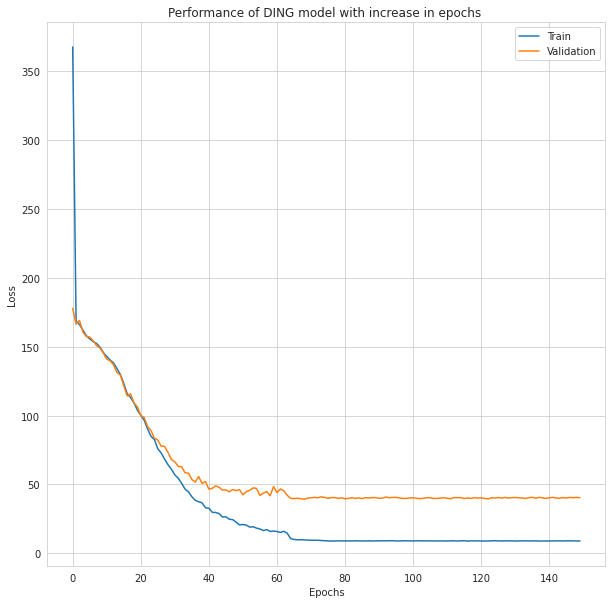

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 133us/step - loss: 314.3804 - val_loss: 168.9105

Epoch 00001: val_loss improved from inf to 168.91053, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.6_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 84us/step - loss: 166.5545 - val_loss: 161.8927

Epoch 00002: val_loss improved from 168.91053 to 161.89272, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.6_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 83us/step - loss: 160.7991 - val_loss: 161.2988

Epoch 00003: val_loss improved from 161.89272 to 161.29877, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.6_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 81us/step - loss: 159.0015 - val_loss: 158.9986

Epoch 00004: val_loss improved from 161.29877 to 158.99864, saving model to Models/weighted/sinter

16239/16239 [==============================] - 1s 79us/step - loss: 33.9723 - val_loss: 51.1498

Epoch 00036: val_loss improved from 53.09308 to 51.14979, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.6_ding_model_best.h5
Epoch 37/150
16239/16239 [==============================] - 1s 81us/step - loss: 32.9305 - val_loss: 53.5632

Epoch 00037: val_loss did not improve from 51.14979
Epoch 38/150
16239/16239 [==============================] - 1s 80us/step - loss: 32.6082 - val_loss: 52.4512

Epoch 00038: val_loss did not improve from 51.14979
Epoch 39/150
16239/16239 [==============================] - 1s 81us/step - loss: 29.5681 - val_loss: 48.0776

Epoch 00039: val_loss improved from 51.14979 to 48.07764, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.6_ding_model_best.h5
Epoch 40/150
16239/16239 [==============================] - 1s 78us/step - loss: 29.3060 - val_loss: 54.4617

Epoch 00040: val_loss did not improve from 48.07764
Epoch 41/150
16239/16239 [=========

16239/16239 [==============================] - 1s 80us/step - loss: 10.3905 - val_loss: 42.7930

Epoch 00080: val_loss did not improve from 42.24304
Epoch 81/150
16239/16239 [==============================] - 1s 79us/step - loss: 10.4221 - val_loss: 42.4234

Epoch 00081: val_loss did not improve from 42.24304
Epoch 82/150
16239/16239 [==============================] - 1s 82us/step - loss: 10.4136 - val_loss: 42.7876

Epoch 00082: val_loss did not improve from 42.24304
Epoch 83/150
16239/16239 [==============================] - 1s 80us/step - loss: 10.6624 - val_loss: 43.1012

Epoch 00083: val_loss did not improve from 42.24304
Epoch 84/150
16239/16239 [==============================] - 1s 79us/step - loss: 10.4917 - val_loss: 42.8175

Epoch 00084: ReduceLROnPlateau reducing learning rate to 1e-08.

Epoch 00084: val_loss did not improve from 42.24304
Epoch 85/150
16239/16239 [==============================] - 1s 80us/step - loss: 10.4144 - val_loss: 42.7302

Epoch 00085: val_loss did no

16239/16239 [==============================] - 1s 82us/step - loss: 10.5559 - val_loss: 42.7762

Epoch 00130: val_loss did not improve from 42.24304
Epoch 131/150
16239/16239 [==============================] - 1s 80us/step - loss: 10.5108 - val_loss: 42.7378

Epoch 00131: val_loss did not improve from 42.24304
Epoch 132/150
16239/16239 [==============================] - 1s 79us/step - loss: 10.4092 - val_loss: 43.2781

Epoch 00132: val_loss did not improve from 42.24304
Epoch 133/150
16239/16239 [==============================] - 1s 82us/step - loss: 10.6059 - val_loss: 42.9431

Epoch 00133: val_loss did not improve from 42.24304
Epoch 134/150
16239/16239 [==============================] - 1s 78us/step - loss: 10.4868 - val_loss: 42.8256

Epoch 00134: val_loss did not improve from 42.24304
Epoch 135/150
16239/16239 [==============================] - 1s 79us/step - loss: 10.4959 - val_loss: 42.7488

Epoch 00135: val_loss did not improve from 42.24304
Epoch 136/150
16239/16239 [=========

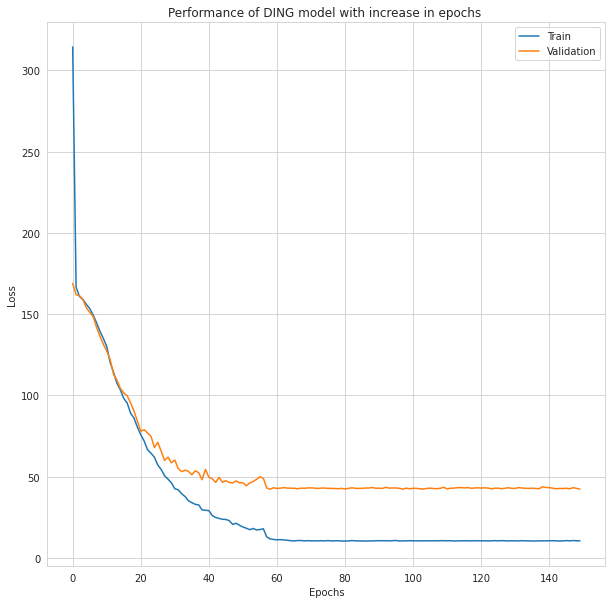

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 134us/step - loss: 342.6481 - val_loss: 169.9088

Epoch 00001: val_loss improved from inf to 169.90881, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.7_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 82us/step - loss: 167.2965 - val_loss: 167.7849

Epoch 00002: val_loss improved from 169.90881 to 167.78494, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.7_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 82us/step - loss: 162.2300 - val_loss: 161.3468

Epoch 00003: val_loss improved from 167.78494 to 161.34680, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.7_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 84us/step - loss: 158.1492 - val_loss: 157.7182

Epoch 00004: val_loss improved from 161.34680 to 157.71821, saving model to Models/weighted/sinter

16239/16239 [==============================] - 1s 80us/step - loss: 32.7601 - val_loss: 49.6853

Epoch 00035: val_loss improved from 51.30851 to 49.68532, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.7_ding_model_best.h5
Epoch 36/150
16239/16239 [==============================] - 1s 79us/step - loss: 31.5548 - val_loss: 47.2637

Epoch 00036: val_loss improved from 49.68532 to 47.26366, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.7_ding_model_best.h5
Epoch 37/150
16239/16239 [==============================] - 1s 79us/step - loss: 30.1522 - val_loss: 48.8832

Epoch 00037: val_loss did not improve from 47.26366
Epoch 38/150
16239/16239 [==============================] - 1s 79us/step - loss: 28.9973 - val_loss: 44.8352

Epoch 00038: val_loss improved from 47.26366 to 44.83516, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.7_ding_model_best.h5
Epoch 39/150
16239/16239 [==============================] - 1s 79us/step - loss: 27.8417 - val_loss: 47.3380

Epo

16239/16239 [==============================] - 1s 82us/step - loss: 8.3056 - val_loss: 36.4081

Epoch 00077: val_loss did not improve from 35.77943
Epoch 78/150
16239/16239 [==============================] - 1s 79us/step - loss: 8.2725 - val_loss: 36.7101

Epoch 00078: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00078: val_loss did not improve from 35.77943
Epoch 79/150
16239/16239 [==============================] - 1s 82us/step - loss: 8.5030 - val_loss: 37.0890

Epoch 00079: val_loss did not improve from 35.77943
Epoch 80/150
16239/16239 [==============================] - 1s 79us/step - loss: 8.4004 - val_loss: 36.4330

Epoch 00080: val_loss did not improve from 35.77943
Epoch 81/150
16239/16239 [==============================] - 1s 82us/step - loss: 8.3878 - val_loss: 36.8853

Epoch 00081: val_loss did not improve from 35.77943
Epoch 82/150
16239/16239 [==============================] - 1s 81us/step - loss: 8.4153 - val_loss: 36.2391

Epoch 00082: val_

16239/16239 [==============================] - 1s 79us/step - loss: 8.3538 - val_loss: 36.3738

Epoch 00126: val_loss did not improve from 35.75237
Epoch 127/150
16239/16239 [==============================] - 1s 82us/step - loss: 8.3697 - val_loss: 36.5692

Epoch 00127: val_loss did not improve from 35.75237
Epoch 128/150
16239/16239 [==============================] - 1s 82us/step - loss: 8.3560 - val_loss: 36.9926

Epoch 00128: val_loss did not improve from 35.75237
Epoch 129/150
16239/16239 [==============================] - 1s 82us/step - loss: 8.3560 - val_loss: 35.9957

Epoch 00129: val_loss did not improve from 35.75237
Epoch 130/150
16239/16239 [==============================] - 1s 80us/step - loss: 8.4249 - val_loss: 36.7812

Epoch 00130: val_loss did not improve from 35.75237
Epoch 131/150
16239/16239 [==============================] - 1s 82us/step - loss: 8.4118 - val_loss: 36.1694

Epoch 00131: val_loss did not improve from 35.75237
Epoch 132/150
16239/16239 [===============

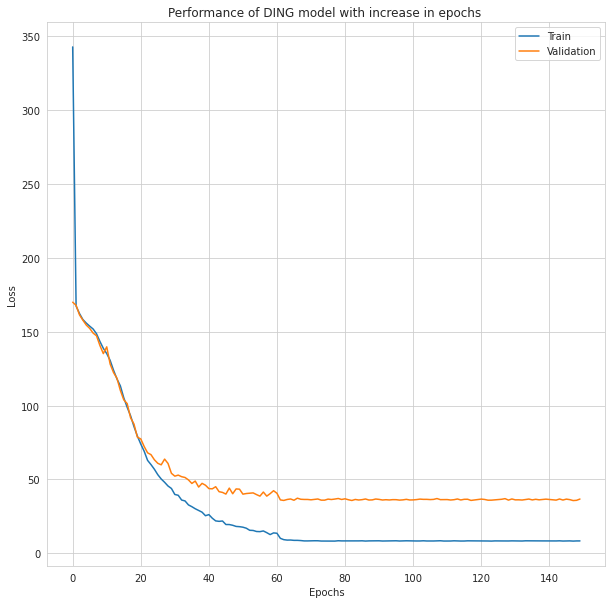

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 3s 163us/step - loss: 342.7350 - val_loss: 171.3168

Epoch 00001: val_loss improved from inf to 171.31677, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.8_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 86us/step - loss: 167.3460 - val_loss: 166.1503

Epoch 00002: val_loss improved from 171.31677 to 166.15032, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.8_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 86us/step - loss: 162.5462 - val_loss: 160.3277

Epoch 00003: val_loss improved from 166.15032 to 160.32775, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.8_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 79us/step - loss: 157.8424 - val_loss: 156.5829

Epoch 00004: val_loss improved from 160.32775 to 156.58288, saving model to Models/weighted/sinter

16239/16239 [==============================] - 1s 78us/step - loss: 29.8298 - val_loss: 42.5400

Epoch 00035: val_loss improved from 46.05470 to 42.54005, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.8_ding_model_best.h5
Epoch 36/150
16239/16239 [==============================] - 1s 81us/step - loss: 27.4333 - val_loss: 41.0457

Epoch 00036: val_loss improved from 42.54005 to 41.04575, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.8_ding_model_best.h5
Epoch 37/150
16239/16239 [==============================] - 1s 84us/step - loss: 26.3705 - val_loss: 43.6846

Epoch 00037: val_loss did not improve from 41.04575
Epoch 38/150
16239/16239 [==============================] - 1s 81us/step - loss: 25.6530 - val_loss: 41.9449

Epoch 00038: val_loss did not improve from 41.04575
Epoch 39/150
16239/16239 [==============================] - 1s 81us/step - loss: 23.0969 - val_loss: 42.0046

Epoch 00039: val_loss did not improve from 41.04575
Epoch 40/150
16239/16239 [=========

16239/16239 [==============================] - 1s 85us/step - loss: 7.3435 - val_loss: 33.5020

Epoch 00078: val_loss did not improve from 32.47263
Epoch 79/150
16239/16239 [==============================] - 1s 79us/step - loss: 7.3353 - val_loss: 33.2318

Epoch 00079: val_loss did not improve from 32.47263
Epoch 80/150
16239/16239 [==============================] - 1s 81us/step - loss: 7.3493 - val_loss: 33.4323

Epoch 00080: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00080: val_loss did not improve from 32.47263
Epoch 81/150
16239/16239 [==============================] - 1s 81us/step - loss: 7.2852 - val_loss: 33.2974

Epoch 00081: val_loss did not improve from 32.47263
Epoch 82/150
16239/16239 [==============================] - 1s 82us/step - loss: 7.2742 - val_loss: 33.1987

Epoch 00082: val_loss did not improve from 32.47263
Epoch 83/150
16239/16239 [==============================] - 1s 78us/step - loss: 7.2419 - val_loss: 33.2009

Epoch 00083: val_

16239/16239 [==============================] - 1s 79us/step - loss: 7.3630 - val_loss: 33.3288

Epoch 00127: val_loss did not improve from 32.47263
Epoch 128/150
16239/16239 [==============================] - 1s 79us/step - loss: 7.3110 - val_loss: 33.0900

Epoch 00128: val_loss did not improve from 32.47263
Epoch 129/150
16239/16239 [==============================] - 1s 80us/step - loss: 7.2019 - val_loss: 33.3014

Epoch 00129: val_loss did not improve from 32.47263
Epoch 130/150
16239/16239 [==============================] - 1s 81us/step - loss: 7.3604 - val_loss: 33.1244

Epoch 00130: val_loss did not improve from 32.47263
Epoch 131/150
16239/16239 [==============================] - 1s 80us/step - loss: 7.3226 - val_loss: 32.8561

Epoch 00131: val_loss did not improve from 32.47263
Epoch 132/150
16239/16239 [==============================] - 1s 80us/step - loss: 7.2684 - val_loss: 33.2464

Epoch 00132: val_loss did not improve from 32.47263
Epoch 133/150
16239/16239 [===============

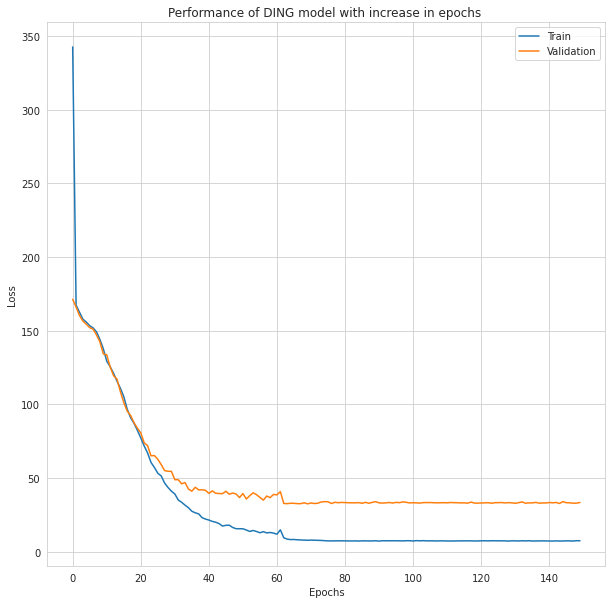

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 151us/step - loss: 318.0607 - val_loss: 170.5343

Epoch 00001: val_loss improved from inf to 170.53430, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.9_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 81us/step - loss: 167.8123 - val_loss: 162.8845

Epoch 00002: val_loss improved from 170.53430 to 162.88454, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.9_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 80us/step - loss: 161.5519 - val_loss: 160.6520

Epoch 00003: val_loss improved from 162.88454 to 160.65203, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.9_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 81us/step - loss: 157.1238 - val_loss: 156.0042

Epoch 00004: val_loss improved from 160.65203 to 156.00419, saving model to Models/weighted/sinter

Epoch 36/150
16239/16239 [==============================] - 1s 85us/step - loss: 42.1205 - val_loss: 57.2912

Epoch 00036: val_loss improved from 59.79266 to 57.29118, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.9_ding_model_best.h5
Epoch 37/150
16239/16239 [==============================] - 1s 83us/step - loss: 40.8708 - val_loss: 58.8759

Epoch 00037: val_loss did not improve from 57.29118
Epoch 38/150
16239/16239 [==============================] - 1s 83us/step - loss: 39.8031 - val_loss: 54.3592

Epoch 00038: val_loss improved from 57.29118 to 54.35920, saving model to Models/weighted/sinter_temp_bulk_mod_1_0.9_ding_model_best.h5
Epoch 39/150
16239/16239 [==============================] - 1s 79us/step - loss: 38.2501 - val_loss: 59.8534

Epoch 00039: val_loss did not improve from 54.35920
Epoch 40/150
16239/16239 [==============================] - 1s 82us/step - loss: 36.2127 - val_loss: 58.3188

Epoch 00040: val_loss did not improve from 54.35920
Epoch 41/150
16239/162

16239/16239 [==============================] - 1s 79us/step - loss: 11.7057 - val_loss: 44.4142

Epoch 00078: val_loss did not improve from 43.63544
Epoch 79/150
16239/16239 [==============================] - 1s 82us/step - loss: 11.6823 - val_loss: 44.2984

Epoch 00079: val_loss did not improve from 43.63544
Epoch 80/150
16239/16239 [==============================] - 1s 80us/step - loss: 11.6156 - val_loss: 43.7309

Epoch 00080: val_loss did not improve from 43.63544
Epoch 81/150
16239/16239 [==============================] - 1s 80us/step - loss: 11.8019 - val_loss: 43.9457

Epoch 00081: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00081: val_loss did not improve from 43.63544
Epoch 82/150
16239/16239 [==============================] - 1s 81us/step - loss: 11.6613 - val_loss: 43.8297

Epoch 00082: val_loss did not improve from 43.63544
Epoch 83/150
16239/16239 [==============================] - 1s 82us/step - loss: 11.6619 - val_loss: 43.9174

Epoch 00083:


Epoch 00126: val_loss did not improve from 43.46102
Epoch 127/150
16239/16239 [==============================] - 1s 81us/step - loss: 11.7250 - val_loss: 43.9155

Epoch 00127: val_loss did not improve from 43.46102
Epoch 128/150
16239/16239 [==============================] - 1s 81us/step - loss: 11.7375 - val_loss: 44.3986

Epoch 00128: val_loss did not improve from 43.46102
Epoch 129/150
16239/16239 [==============================] - 1s 81us/step - loss: 11.7269 - val_loss: 44.0810

Epoch 00129: val_loss did not improve from 43.46102
Epoch 130/150
16239/16239 [==============================] - 1s 85us/step - loss: 11.6520 - val_loss: 43.9883

Epoch 00130: val_loss did not improve from 43.46102
Epoch 131/150
16239/16239 [==============================] - 1s 79us/step - loss: 11.6878 - val_loss: 44.0666

Epoch 00131: val_loss did not improve from 43.46102
Epoch 132/150
16239/16239 [==============================] - 1s 81us/step - loss: 11.8084 - val_loss: 44.5177

Epoch 00132: val_loss

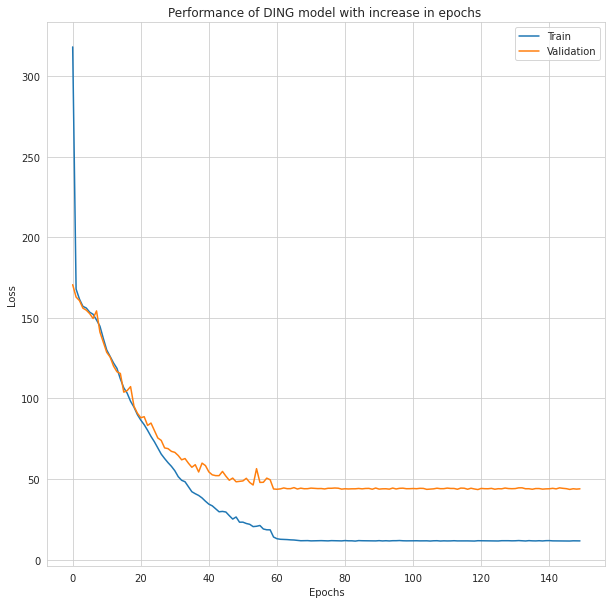

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 144us/step - loss: 330.3431 - val_loss: 169.4819

Epoch 00001: val_loss improved from inf to 169.48191, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.1_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 85us/step - loss: 168.1090 - val_loss: 171.1031

Epoch 00002: val_loss did not improve from 169.48191
Epoch 3/150
16239/16239 [==============================] - 1s 81us/step - loss: 162.9522 - val_loss: 161.5496

Epoch 00003: val_loss improved from 169.48191 to 161.54965, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.1_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 84us/step - loss: 158.8090 - val_loss: 159.6662

Epoch 00004: val_loss improved from 161.54965 to 159.66619, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.1_ding_model_best.h5
Epoch 5/150
16239/16239 [====================

16239/16239 [==============================] - 1s 80us/step - loss: 36.9365 - val_loss: 52.7773

Epoch 00035: val_loss improved from 54.87181 to 52.77732, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.1_ding_model_best.h5
Epoch 36/150
16239/16239 [==============================] - 1s 80us/step - loss: 33.4905 - val_loss: 54.3227

Epoch 00036: val_loss did not improve from 52.77732
Epoch 37/150
16239/16239 [==============================] - 1s 79us/step - loss: 32.7256 - val_loss: 49.8211

Epoch 00037: val_loss improved from 52.77732 to 49.82112, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.1_ding_model_best.h5
Epoch 38/150
16239/16239 [==============================] - 1s 80us/step - loss: 30.6581 - val_loss: 50.4018

Epoch 00038: val_loss did not improve from 49.82112
Epoch 39/150
16239/16239 [==============================] - 1s 80us/step - loss: 29.4889 - val_loss: 51.1813

Epoch 00039: val_loss did not improve from 49.82112
Epoch 40/150
16239/16239 [=========

16239/16239 [==============================] - 1s 82us/step - loss: 16.4292 - val_loss: 45.0875

Epoch 00080: val_loss did not improve from 44.70836
Epoch 81/150
16239/16239 [==============================] - 1s 81us/step - loss: 16.5039 - val_loss: 45.2227

Epoch 00081: val_loss did not improve from 44.70836
Epoch 82/150
16239/16239 [==============================] - 1s 84us/step - loss: 16.4051 - val_loss: 45.2050

Epoch 00082: val_loss did not improve from 44.70836
Epoch 83/150
16239/16239 [==============================] - 1s 81us/step - loss: 16.3825 - val_loss: 45.1823

Epoch 00083: val_loss did not improve from 44.70836
Epoch 84/150
16239/16239 [==============================] - 1s 80us/step - loss: 16.4031 - val_loss: 45.2162

Epoch 00084: val_loss did not improve from 44.70836
Epoch 85/150
16239/16239 [==============================] - 1s 80us/step - loss: 16.3459 - val_loss: 45.5683

Epoch 00085: val_loss did not improve from 44.70836
Epoch 86/150
16239/16239 [===============

16239/16239 [==============================] - 1s 80us/step - loss: 16.5097 - val_loss: 45.4853

Epoch 00130: val_loss did not improve from 44.64559
Epoch 131/150
16239/16239 [==============================] - 1s 81us/step - loss: 16.3402 - val_loss: 45.0735

Epoch 00131: val_loss did not improve from 44.64559
Epoch 132/150
16239/16239 [==============================] - 1s 83us/step - loss: 16.3945 - val_loss: 45.2422

Epoch 00132: val_loss did not improve from 44.64559
Epoch 133/150
16239/16239 [==============================] - 1s 82us/step - loss: 16.4662 - val_loss: 45.1409

Epoch 00133: val_loss did not improve from 44.64559
Epoch 134/150
16239/16239 [==============================] - 1s 81us/step - loss: 16.3859 - val_loss: 45.1653

Epoch 00134: val_loss did not improve from 44.64559
Epoch 135/150
16239/16239 [==============================] - 1s 81us/step - loss: 16.5523 - val_loss: 45.2089

Epoch 00135: val_loss did not improve from 44.64559
Epoch 136/150
16239/16239 [=========

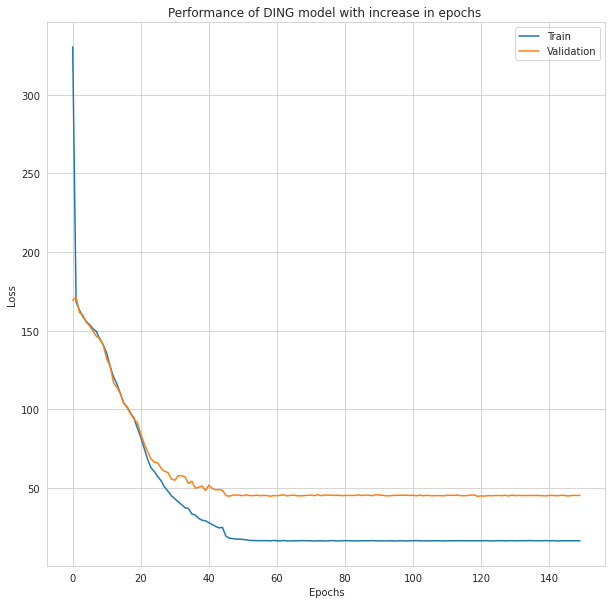

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 152us/step - loss: 346.9290 - val_loss: 174.2248

Epoch 00001: val_loss improved from inf to 174.22480, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.2_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 81us/step - loss: 169.4315 - val_loss: 167.1688

Epoch 00002: val_loss improved from 174.22480 to 167.16882, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.2_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 85us/step - loss: 165.2389 - val_loss: 162.1505

Epoch 00003: val_loss improved from 167.16882 to 162.15050, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.2_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 83us/step - loss: 158.0503 - val_loss: 156.6772

Epoch 00004: val_loss improved from 162.15050 to 156.67718, saving model to Models/weighted/sinter

16239/16239 [==============================] - 1s 84us/step - loss: 47.3206 - val_loss: 62.6087

Epoch 00035: val_loss improved from 62.79119 to 62.60867, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.2_ding_model_best.h5
Epoch 36/150
16239/16239 [==============================] - 1s 81us/step - loss: 44.2773 - val_loss: 62.7898

Epoch 00036: val_loss did not improve from 62.60867
Epoch 37/150
16239/16239 [==============================] - 1s 81us/step - loss: 43.1634 - val_loss: 58.8884

Epoch 00037: val_loss improved from 62.60867 to 58.88843, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.2_ding_model_best.h5
Epoch 38/150
16239/16239 [==============================] - 1s 81us/step - loss: 40.1279 - val_loss: 56.7014

Epoch 00038: val_loss improved from 58.88843 to 56.70142, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.2_ding_model_best.h5
Epoch 39/150
16239/16239 [==============================] - 1s 80us/step - loss: 39.0693 - val_loss: 60.3334

Epo

16239/16239 [==============================] - 1s 80us/step - loss: 12.3897 - val_loss: 44.2040

Epoch 00076: val_loss did not improve from 43.56744
Epoch 77/150
16239/16239 [==============================] - 1s 79us/step - loss: 12.6182 - val_loss: 43.7257

Epoch 00077: val_loss did not improve from 43.56744
Epoch 78/150
16239/16239 [==============================] - 1s 81us/step - loss: 12.4996 - val_loss: 43.9544

Epoch 00078: val_loss did not improve from 43.56744
Epoch 79/150
16239/16239 [==============================] - 1s 82us/step - loss: 12.5285 - val_loss: 43.8074

Epoch 00079: val_loss did not improve from 43.56744
Epoch 80/150
16239/16239 [==============================] - 1s 79us/step - loss: 12.5923 - val_loss: 43.9859

Epoch 00080: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00080: val_loss did not improve from 43.56744
Epoch 81/150
16239/16239 [==============================] - 1s 83us/step - loss: 12.6234 - val_loss: 43.9831

Epoch 00081:


Epoch 00125: val_loss did not improve from 43.56744
Epoch 126/150
16239/16239 [==============================] - 1s 81us/step - loss: 12.6057 - val_loss: 44.0204

Epoch 00126: val_loss did not improve from 43.56744
Epoch 127/150
16239/16239 [==============================] - 1s 80us/step - loss: 12.5041 - val_loss: 44.1820

Epoch 00127: val_loss did not improve from 43.56744
Epoch 128/150
16239/16239 [==============================] - 1s 82us/step - loss: 12.5992 - val_loss: 43.9648

Epoch 00128: val_loss did not improve from 43.56744
Epoch 129/150
16239/16239 [==============================] - 1s 83us/step - loss: 12.5439 - val_loss: 43.8976

Epoch 00129: val_loss did not improve from 43.56744
Epoch 130/150
16239/16239 [==============================] - 1s 79us/step - loss: 12.4587 - val_loss: 43.9977

Epoch 00130: val_loss did not improve from 43.56744
Epoch 131/150
16239/16239 [==============================] - 1s 83us/step - loss: 12.5624 - val_loss: 44.1302

Epoch 00131: val_loss

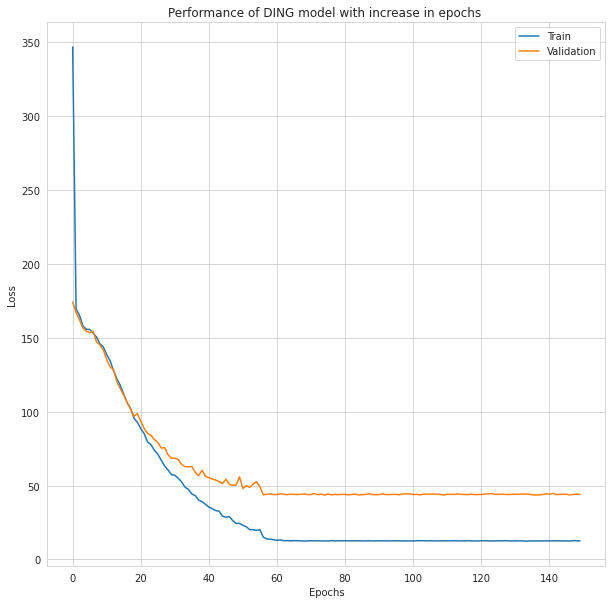

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 151us/step - loss: 327.3345 - val_loss: 169.1847

Epoch 00001: val_loss improved from inf to 169.18466, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.3_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 83us/step - loss: 167.4405 - val_loss: 164.9806

Epoch 00002: val_loss improved from 169.18466 to 164.98062, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.3_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 82us/step - loss: 162.0772 - val_loss: 159.2028

Epoch 00003: val_loss improved from 164.98062 to 159.20277, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.3_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 82us/step - loss: 157.3204 - val_loss: 158.4290

Epoch 00004: val_loss improved from 159.20277 to 158.42898, saving model to Models/weighted/sinter

16239/16239 [==============================] - 1s 81us/step - loss: 32.7659 - val_loss: 51.1246

Epoch 00035: val_loss did not improve from 50.79542
Epoch 36/150
16239/16239 [==============================] - 1s 81us/step - loss: 31.9176 - val_loss: 47.8369

Epoch 00036: val_loss improved from 50.79542 to 47.83689, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.3_ding_model_best.h5
Epoch 37/150
16239/16239 [==============================] - 1s 81us/step - loss: 29.7160 - val_loss: 48.9300

Epoch 00037: val_loss did not improve from 47.83689
Epoch 38/150
16239/16239 [==============================] - 1s 81us/step - loss: 29.1929 - val_loss: 49.5212

Epoch 00038: val_loss did not improve from 47.83689
Epoch 39/150
16239/16239 [==============================] - 1s 82us/step - loss: 27.3349 - val_loss: 50.7190

Epoch 00039: val_loss did not improve from 47.83689
Epoch 40/150
16239/16239 [==============================] - 1s 81us/step - loss: 26.7976 - val_loss: 49.1042

Epoch 000


Epoch 00080: val_loss did not improve from 41.20164
Epoch 81/150
16239/16239 [==============================] - 1s 81us/step - loss: 16.8712 - val_loss: 41.5539

Epoch 00081: val_loss did not improve from 41.20164
Epoch 82/150
16239/16239 [==============================] - 1s 79us/step - loss: 16.7801 - val_loss: 41.6328

Epoch 00082: val_loss did not improve from 41.20164
Epoch 83/150
16239/16239 [==============================] - 1s 84us/step - loss: 16.8342 - val_loss: 41.4336

Epoch 00083: val_loss did not improve from 41.20164
Epoch 84/150
16239/16239 [==============================] - 1s 82us/step - loss: 16.9163 - val_loss: 41.6810

Epoch 00084: val_loss did not improve from 41.20164
Epoch 85/150
16239/16239 [==============================] - 1s 82us/step - loss: 16.9168 - val_loss: 41.7781

Epoch 00085: val_loss did not improve from 41.20164
Epoch 86/150
16239/16239 [==============================] - 1s 81us/step - loss: 16.7885 - val_loss: 41.2901

Epoch 00086: val_loss did n


Epoch 00130: val_loss did not improve from 41.05864
Epoch 131/150
16239/16239 [==============================] - 1s 82us/step - loss: 16.7556 - val_loss: 41.9129

Epoch 00131: val_loss did not improve from 41.05864
Epoch 132/150
16239/16239 [==============================] - 1s 81us/step - loss: 16.9223 - val_loss: 41.4686

Epoch 00132: val_loss did not improve from 41.05864
Epoch 133/150
16239/16239 [==============================] - 1s 81us/step - loss: 16.7788 - val_loss: 41.7991

Epoch 00133: val_loss did not improve from 41.05864
Epoch 134/150
16239/16239 [==============================] - 1s 80us/step - loss: 16.7661 - val_loss: 41.5740

Epoch 00134: val_loss did not improve from 41.05864
Epoch 135/150
16239/16239 [==============================] - 1s 82us/step - loss: 16.7432 - val_loss: 41.9897

Epoch 00135: val_loss did not improve from 41.05864
Epoch 136/150
16239/16239 [==============================] - 1s 81us/step - loss: 16.8734 - val_loss: 41.8516

Epoch 00136: val_loss

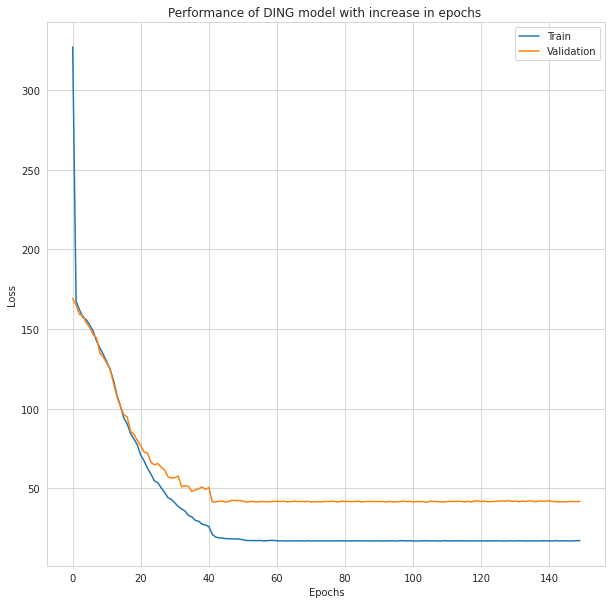

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 2s 154us/step - loss: 334.2861 - val_loss: 170.0252

Epoch 00001: val_loss improved from inf to 170.02518, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.4_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 84us/step - loss: 168.2121 - val_loss: 167.3215

Epoch 00002: val_loss improved from 170.02518 to 167.32150, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.4_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 82us/step - loss: 166.2033 - val_loss: 162.3829

Epoch 00003: val_loss improved from 167.32150 to 162.38293, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.4_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 82us/step - loss: 160.7578 - val_loss: 158.6275

Epoch 00004: val_loss improved from 162.38293 to 158.62747, saving model to Models/weighted/sinter

Epoch 35/150
16239/16239 [==============================] - 1s 80us/step - loss: 37.2953 - val_loss: 54.1976

Epoch 00035: val_loss improved from 54.92660 to 54.19760, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.4_ding_model_best.h5
Epoch 36/150
16239/16239 [==============================] - 1s 84us/step - loss: 35.3386 - val_loss: 52.7197

Epoch 00036: val_loss improved from 54.19760 to 52.71970, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.4_ding_model_best.h5
Epoch 37/150
16239/16239 [==============================] - 1s 84us/step - loss: 35.0936 - val_loss: 50.8547

Epoch 00037: val_loss improved from 52.71970 to 50.85470, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.4_ding_model_best.h5
Epoch 38/150
16239/16239 [==============================] - 1s 81us/step - loss: 32.5483 - val_loss: 49.3694

Epoch 00038: val_loss improved from 50.85470 to 49.36939, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.4_ding_model_best.h5
Epoch 39/150
162

16239/16239 [==============================] - 1s 82us/step - loss: 10.8087 - val_loss: 40.4054

Epoch 00077: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00077: val_loss did not improve from 39.59103
Epoch 78/150
16239/16239 [==============================] - 1s 81us/step - loss: 10.7736 - val_loss: 40.2036

Epoch 00078: val_loss did not improve from 39.59103
Epoch 79/150
16239/16239 [==============================] - 1s 81us/step - loss: 10.8108 - val_loss: 40.2277

Epoch 00079: val_loss did not improve from 39.59103
Epoch 80/150
16239/16239 [==============================] - 1s 82us/step - loss: 10.7368 - val_loss: 39.9366

Epoch 00080: val_loss did not improve from 39.59103
Epoch 81/150
16239/16239 [==============================] - 1s 81us/step - loss: 10.7559 - val_loss: 40.3058

Epoch 00081: val_loss did not improve from 39.59103
Epoch 82/150
16239/16239 [==============================] - 1s 82us/step - loss: 10.8540 - val_loss: 39.9085

Epoch 00082:


Epoch 00126: val_loss did not improve from 39.59103
Epoch 127/150
16239/16239 [==============================] - 1s 82us/step - loss: 10.9176 - val_loss: 39.8379

Epoch 00127: val_loss did not improve from 39.59103
Epoch 128/150
16239/16239 [==============================] - 1s 82us/step - loss: 10.7164 - val_loss: 39.6034

Epoch 00128: val_loss did not improve from 39.59103
Epoch 129/150
16239/16239 [==============================] - 1s 82us/step - loss: 10.6576 - val_loss: 39.9881

Epoch 00129: val_loss did not improve from 39.59103
Epoch 130/150
16239/16239 [==============================] - 1s 82us/step - loss: 10.7718 - val_loss: 40.4682

Epoch 00130: val_loss did not improve from 39.59103
Epoch 131/150
16239/16239 [==============================] - 1s 84us/step - loss: 10.8685 - val_loss: 39.8786

Epoch 00131: val_loss did not improve from 39.59103
Epoch 132/150
16239/16239 [==============================] - 1s 82us/step - loss: 10.8313 - val_loss: 39.8796

Epoch 00132: val_loss

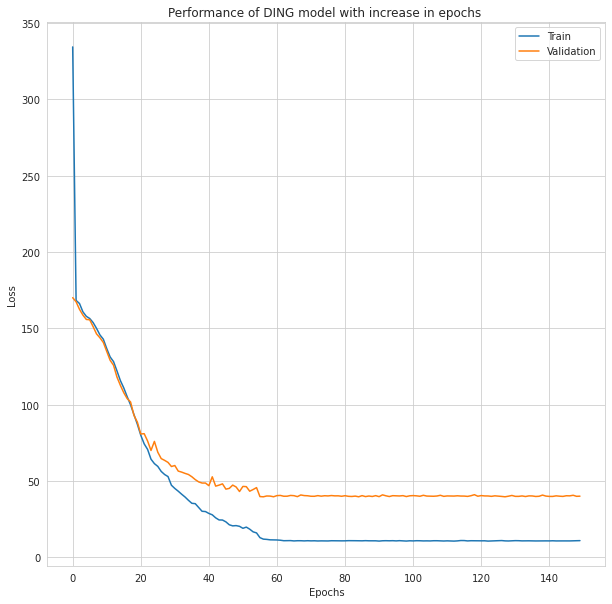

Train on 16239 samples, validate on 4060 samples
Epoch 1/150
16239/16239 [==============================] - 3s 163us/step - loss: 341.0924 - val_loss: 170.0075

Epoch 00001: val_loss improved from inf to 170.00749, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.5_ding_model_best.h5
Epoch 2/150
16239/16239 [==============================] - 1s 88us/step - loss: 168.2033 - val_loss: 167.4950

Epoch 00002: val_loss improved from 170.00749 to 167.49503, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.5_ding_model_best.h5
Epoch 3/150
16239/16239 [==============================] - 1s 89us/step - loss: 165.2844 - val_loss: 161.2737

Epoch 00003: val_loss improved from 167.49503 to 161.27375, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.5_ding_model_best.h5
Epoch 4/150
16239/16239 [==============================] - 1s 83us/step - loss: 159.8369 - val_loss: 157.7212

Epoch 00004: val_loss improved from 161.27375 to 157.72121, saving model to Models/weighted/sinter

16239/16239 [==============================] - 1s 83us/step - loss: 37.6830 - val_loss: 52.7927

Epoch 00035: val_loss improved from 52.94627 to 52.79272, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.5_ding_model_best.h5
Epoch 36/150
16239/16239 [==============================] - 1s 85us/step - loss: 36.5478 - val_loss: 52.0192

Epoch 00036: val_loss improved from 52.79272 to 52.01921, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.5_ding_model_best.h5
Epoch 37/150
16239/16239 [==============================] - 1s 86us/step - loss: 35.6835 - val_loss: 50.7143

Epoch 00037: val_loss improved from 52.01921 to 50.71427, saving model to Models/weighted/sinter_temp_bulk_mod_2_0.5_ding_model_best.h5
Epoch 38/150
16239/16239 [==============================] - 1s 86us/step - loss: 31.9163 - val_loss: 50.8152

Epoch 00038: val_loss did not improve from 50.71427
Epoch 39/150
16239/16239 [==============================] - 1s 84us/step - loss: 31.7720 - val_loss: 47.0906

Epo

16239/16239 [==============================] - 1s 82us/step - loss: 17.7178 - val_loss: 41.8870

Epoch 00079: val_loss did not improve from 41.62054
Epoch 80/150
16239/16239 [==============================] - 1s 88us/step - loss: 17.7205 - val_loss: 41.8184

Epoch 00080: val_loss did not improve from 41.62054
Epoch 81/150
16239/16239 [==============================] - 1s 85us/step - loss: 17.6657 - val_loss: 41.7972

Epoch 00081: val_loss did not improve from 41.62054
Epoch 82/150
16239/16239 [==============================] - 1s 87us/step - loss: 17.5707 - val_loss: 41.9276

Epoch 00082: val_loss did not improve from 41.62054
Epoch 83/150
16239/16239 [==============================] - 1s 87us/step - loss: 17.6586 - val_loss: 42.1251

Epoch 00083: val_loss did not improve from 41.62054
Epoch 84/150
16239/16239 [==============================] - 1s 86us/step - loss: 17.6436 - val_loss: 42.0558

Epoch 00084: val_loss did not improve from 41.62054
Epoch 85/150
16239/16239 [===============

In [ ]:
# for prop in ['form_e', 'band_gap', 'bulk_mod', 'shear_mod', 'sinter_temp', 'calcine_temp']:
for iteration in range(1, 4):
    for weight in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        train_model("sinter_temp", "bulk_mod", str(iteration), str(weight))